In [58]:
import pandas as pd
import glob
import os
folder_path = '/Users/souravm/Documents/fund_analysis/mutualfund_analysis/Raw_data'
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
# Function to process files based on their identifier (1, 2, 3)
def process_files(files, identifier):
    dataframes_list = []
    
    for file in files:
        df = pd.read_csv(file)

        # Add 'Fund Type' based on the file name
        if 'Debt' in file:
            df['Fund Type'] = 'Debt'
        elif 'Equity' in file:
            df['Fund Type'] = 'Equity'
        elif 'Hybrid' in file:
            df['Fund Type'] = 'Hybrid'
        elif 'Commodity' in file:
            df['Fund Type'] = 'Commodity'
        else:
            pass

        print(f"Processed file: {file}")
        dataframes_list.append(df)

    # Combine the DataFrames if any were processed
    if dataframes_list:
        combined_df = pd.concat(dataframes_list, ignore_index=True)
        print(f"Combined DataFrame {identifier}: Length = {len(combined_df)}")
        return combined_df
    else:
        print(f"No files with '{identifier}' in the name were found.")
        return None

# Filter files with '1', '2', and '3' in the name
files_with_one = [file for file in csv_files if '1' in file]
files_with_two = [file for file in csv_files if '2' in file]
files_with_three = [file for file in csv_files if '3' in file]

# Process each set of files
df_1 = process_files(files_with_one, '1')
df_2 = process_files(files_with_two, '2')
df_3 = process_files(files_with_three, '3')

# Merge the DataFrames on the common column (assumed to be the first column)
if df_1 is not None and df_2 is not None and df_3 is not None:
    combined_df = pd.merge(df_1, df_2, on=df_1.columns[0], how='outer')
    combined_df = pd.merge(combined_df, df_3, on=combined_df.columns[0], how='outer')

    # Step 1: Drop columns with '_x' and '_y' suffixes, but keep the original column
    columns_to_drop = [col for col in combined_df.columns if col.endswith('_x') or col.endswith('_y')]
    combined_df.drop(columns=columns_to_drop, inplace=True)

    # Step 2: Exclude any columns that contain '%Other%' in their name
    columns_to_keep = [col for col in combined_df.columns if 'Other' not in col]
    combined_df = combined_df[columns_to_keep]

    print("Combined DataFrame after dropping '_x', '_y' and excluding '%Other%' columns:")
    # print(combined_df.columns)
else:
    print("One or more DataFrames were empty, skipping the merge.")

Processed file: /Users/souravm/Documents/fund_analysis/mutualfund_analysis/Raw_data/MF_Equity_1.csv
Processed file: /Users/souravm/Documents/fund_analysis/mutualfund_analysis/Raw_data/MF_Hybrid_1.csv
Processed file: /Users/souravm/Documents/fund_analysis/mutualfund_analysis/Raw_data/MF_Debt_1.csv
Processed file: /Users/souravm/Documents/fund_analysis/mutualfund_analysis/Raw_data/MF_Commodity_1.csv
Combined DataFrame 1: Length = 1461
Processed file: /Users/souravm/Documents/fund_analysis/mutualfund_analysis/Raw_data/MF_Equity_2.csv
Processed file: /Users/souravm/Documents/fund_analysis/mutualfund_analysis/Raw_data/MF_Hybrid_2.csv
Processed file: /Users/souravm/Documents/fund_analysis/mutualfund_analysis/Raw_data/MF_Debt_2.csv
Processed file: /Users/souravm/Documents/fund_analysis/mutualfund_analysis/Raw_data/MF_Commodity_2.csv
Combined DataFrame 2: Length = 1461
Processed file: /Users/souravm/Documents/fund_analysis/mutualfund_analysis/Raw_data/MF_Equity_3.csv
Processed file: /Users/sou

# Analysis

In [101]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [73]:
print(combined_df.columns)

Index(['Name', 'Expense Ratio', 'Absolute Returns - 3M',
       'Absolute Returns - 6M', 'Absolute Returns - 1Y', 'CAGR 3Y', 'CAGR 5Y',
       'CAGR 10Y', 'Alpha', 'Volatility', 'Category St Dev',
       'SEBI Risk Category', '% Debt Holding', '% Equity Holding',
       '% Largecap Holding', '% Midcap Holding', '% Smallcap Holding',
       'PE Ratio', 'Category PE Ratio', 'Sharpe Ratio', 'Sortino Ratio',
       'Sub Category', 'Plan', 'AUM', 'Time since inception', 'Benchmark',
       'Exit Load', 'Lock-in', 'Minimum Lumpsum', 'Minimum SIP', 'NAV',
       'Fund Type'],
      dtype='object')


In [79]:
combined_df['Fund Type'].value_counts()

Fund Type
Equity       678
Debt         509
Hybrid       159
Commodity    121
Name: count, dtype: int64

<Axes: xlabel='Fund Type', ylabel='CAGR 10Y'>

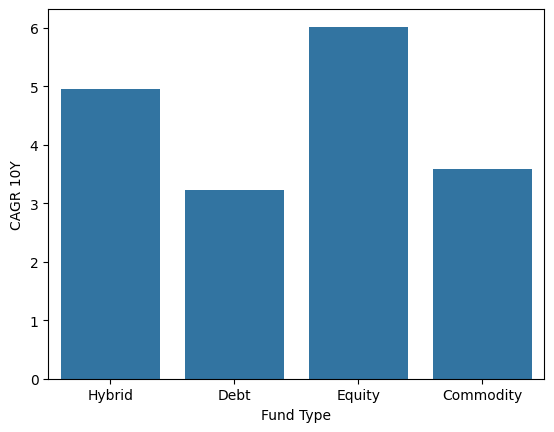

In [86]:
sns.barplot(data=combined_df, x='Fund Type', y='CAGR 10Y', errorbar=('ci', False))

<Axes: xlabel='Fund Type', ylabel='Time since inception'>

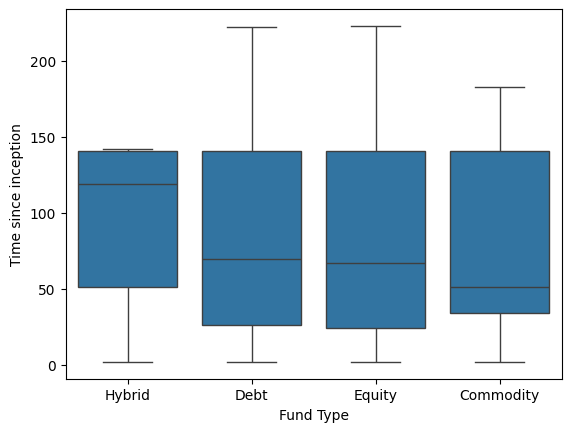

In [88]:
sns.boxplot(data=combined_df, x='Fund Type', y='Time since inception')

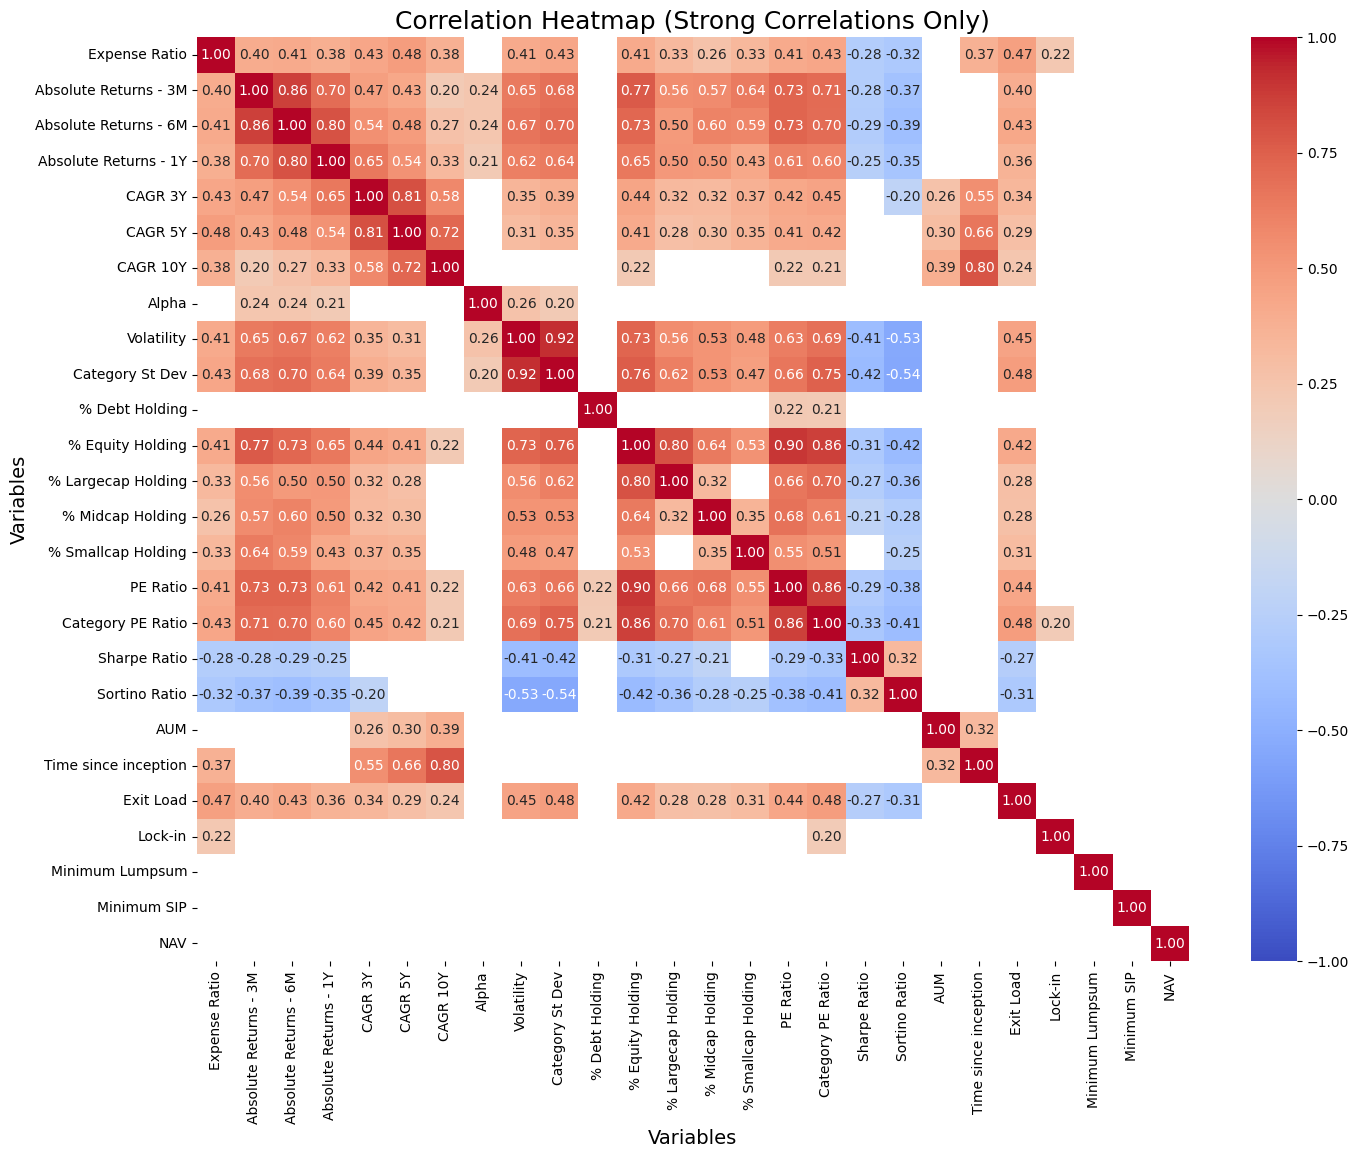

In [103]:
# Select only numeric columns, including integers and floats
numeric_df = combined_df.select_dtypes(include=['number'])

# Compute the correlation matrix of numeric columns
corr_matrix = numeric_df.corr()

# Filter the matrix to keep only strong correlations and mask the rest
mask = np.abs(corr_matrix) < 0.2
strong_corr_matrix = corr_matrix.copy()
strong_corr_matrix[mask] = np.nan

# Set the size of the figure
plt.figure(figsize=(16, 12))  # Adjust width and height to make the figure larger

# Create the heatmap
sns.heatmap(data=strong_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, mask=mask)

# Set labels and title for clarity
plt.title('Correlation Heatmap (Strong Correlations Only)', fontsize=18)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Variables', fontsize=14)

# Show the plot
plt.show()